# Automatic Registration Step 1: Rough Alignment
This step involves doing **registration on downsampled thumbnail images**. We have a reference brain DK52 whose structures are well annotated both by Beth manually and by Kui's detection code automatically. The goal of this step is to find the best transformation from DK52 to another brain we study, so that we could use this transformation to bring DK52 structure annotations to the new brain, as starting points for Kui's detection later.

Outline:
- [Loading Data](#Loading-Data)
- [Registration](#Registration)
    - [Centered Transformation](#Centered-Transformation)
    - [Affine Transformation](#Affine-Transformation)
    - [Demons Transformattion](#Demons-Transformation)
- [Saving Result](#Saving-Result)

In [1]:
%load_ext autoreload
%autoreload 2
from ipywidgets import interact, fixed
from IPython.display import clear_output

In [2]:
from pathlib import Path

import SimpleITK as sitk
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import toolbox.sitk

The following are some utility functions used for plotting, copied from http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/60_Registration_Introduction.html.

In [3]:
# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

## Loading Data

In [4]:
mov_brain = 'DK52'
fix_brain = 'DK43'
# Full resolution is (0.325, 0.325, 20) um
# Thumbnails are downsampled by (32, 32, 1), so
thumb_spacing = (10.4, 10.4, 20.0) # in um

data_dir = Path('/net/birdstore/Active_Atlas_Data/data_root/pipeline_data')
mov_img_thumb_dir = data_dir / mov_brain / 'preps/CH1/thumbnail_aligned'
fix_img_thumb_dir = data_dir / fix_brain / 'preps/CH1/thumbnail_aligned'

In [5]:
%%time
moving_image = toolbox.sitk.load_image_dir(mov_img_thumb_dir, spacing=thumb_spacing)

CPU times: user 18.1 s, sys: 4.99 s, total: 23.1 s
Wall time: 24.3 s


In [7]:
%%time
fixed_image = toolbox.sitk.load_image_dir(fix_img_thumb_dir, spacing=thumb_spacing)

CPU times: user 12.2 s, sys: 3.76 s, total: 16 s
Wall time: 14.3 s


In [7]:
# Registration later requires the sitkFloat32 type,
# so we do the casting once and for all here
moving_image = sitk.Cast(moving_image, sitk.sitkFloat32)
fixed_image = sitk.Cast(fixed_image, sitk.sitkFloat32)

In [8]:
interact(
    display_images_with_alpha,
    image_z=(0,fixed_image.GetSize()[2]-1),
    alpha=(0.0,1.0,0.05), fixed=fixed(fixed_image), moving=fixed(moving_image)
);

interactive(children=(IntSlider(value=195, description='image_z', max=391), FloatSlider(value=0.5, description…

## Registration
We will do a multi-step registration here. Each step generates a transformation that serves as the initial transformation for the next step.

### Centered Transformation
We start with a simple transformatioin that basically align the centers of 2 images using a translation.

In [9]:
%%time
centered_transform = sitk.CenteredTransformInitializer(
    fixed_image, moving_image, 
    sitk.AffineTransform(3), 
    sitk.CenteredTransformInitializerFilter.GEOMETRY
)

CPU times: user 258 µs, sys: 0 ns, total: 258 µs
Wall time: 216 µs


In [10]:
print(centered_transform)

itk::simple::Transform
 AffineTransform (0x55a87b806970)
   RTTI typeinfo:   itk::AffineTransform<double, 3u>
   Reference Count: 1
   Modified Time: 174915
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1 0 0 
     0 1 0 
     0 0 1 
   Offset: [1788.8, 650, 940]
   Center: [8767.2, 5194.8, 3910]
   Translation: [1788.8, 650, 940]
   Inverse: 
     1 0 0 
     0 1 0 
     0 0 1 
   Singular: 0



In [11]:
transform = centered_transform
moving_resampled = sitk.Resample(
    moving_image, fixed_image, transform,
    sitk.sitkLinear, 0.0, moving_image.GetPixelID()
)
interact(
    display_images_with_alpha,
    image_z=(0,fixed_image.GetSize()[2]-1),
    alpha=(0.0,1.0,0.05), fixed=fixed(fixed_image), moving=fixed(moving_resampled)
);

interactive(children=(IntSlider(value=195, description='image_z', max=391), FloatSlider(value=0.5, description…

### Affine Transformation
Then we continue with a general affine transformation.

Reference: http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/60_Registration_Introduction.html

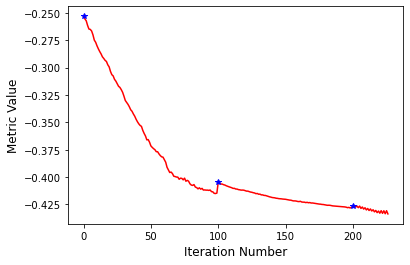

CPU times: user 53min 8s, sys: 2min 10s, total: 55min 19s
Wall time: 7min 28s


<SimpleITK.SimpleITK.Transform; proxy of <Swig Object of type 'itk::simple::Transform *' at 0x7fdd1b1e42a0> >

In [12]:
%%time
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetInterpolator(sitk.sitkLinear)

# Metric
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

# Optimizer
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0,
    numberOfIterations=100,
    convergenceMinimumValue=1e-6,
    convergenceWindowSize=10
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Transformation
affine_transform = sitk.AffineTransform(centered_transform)    
registration_method.SetInitialTransform(affine_transform)

# Multi-resolution           
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Plotting
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

registration_method.Execute(fixed_image, moving_image);

In [13]:
print(f'Final metric value: {registration_method.GetMetricValue()}')
print(f'Optimizer\'s stopping condition, {registration_method.GetOptimizerStopConditionDescription()}')

Final metric value: -0.4304609713145082
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 27.


In [14]:
print(affine_transform)

itk::simple::AffineTransform
 AffineTransform (0x55a87b8029b0)
   RTTI typeinfo:   itk::AffineTransform<double, 3u>
   Reference Count: 3
   Modified Time: 15293217
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.970459 0.180948 -0.0253713 
     -0.242278 1.01319 -0.0809535 
     -0.00583195 0.0665768 1.03528 
   Offset: [572.071, 3074.15, -148.14]
   Center: [8767.2, 5194.8, 3910]
   Translation: [1153.87, 702.022, 284.53]
   Inverse: 
     0.986355 -0.176836 0.0103447 
     0.235097 0.939791 0.0792482 
     -0.00956231 -0.0614322 0.960884 
   Singular: 0



In [15]:
transform = affine_transform
moving_resampled = sitk.Resample(
    moving_image, fixed_image, transform,
    sitk.sitkLinear, 0.0, moving_image.GetPixelID()
)
interact(
    display_images_with_alpha,
    image_z=(0,fixed_image.GetSize()[2]-1),
    alpha=(0.0,1.0,0.05), fixed=fixed(fixed_image), moving=fixed(moving_resampled)
);

interactive(children=(IntSlider(value=195, description='image_z', max=391), FloatSlider(value=0.5, description…

### Demons Transformation
Finally, we refine the registration with a nonlinear transformation.

Reference: http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/66_Registration_Demons.html

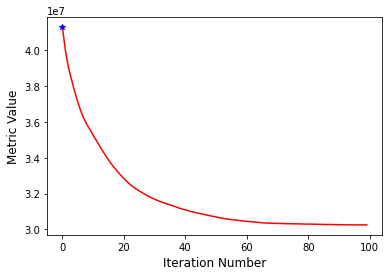

CPU times: user 47min 33s, sys: 1min 29s, total: 49min 2s
Wall time: 5min 3s


<SimpleITK.SimpleITK.Transform; proxy of <Swig Object of type 'itk::simple::Transform *' at 0x7fdd1af46ea0> >

In [16]:
%%time
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetInterpolator(sitk.sitkLinear)

# Metric
registration_method.SetMetricAsDemons(10) #intensities are equal if the difference is less than 10HU

# Optimizer
# Running the Demons registration with the conjugate gradient optimizer takes a long time
# which is why the code below uses gradient descent.
# If you are more interested in accuracy and have the time
# then switch to the conjugate gradient optimizer.
#registration_method.SetOptimizerAsConjugateGradientLineSearch(...)
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0,
    numberOfIterations=100,
    convergenceMinimumValue=1e-6,
    convergenceWindowSize=10
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Transformation
transform_to_displacment_field_filter = sitk.TransformToDisplacementFieldFilter()
transform_to_displacment_field_filter.SetReferenceImage(fixed_image)
demons_transform = sitk.DisplacementFieldTransform(transform_to_displacment_field_filter.Execute(affine_transform))
# Regularization (update field - viscous, total field - elastic)
demons_transform.SetSmoothingGaussianOnUpdate(
    varianceForUpdateField=0.0,
    varianceForTotalField=2.0
)
registration_method.SetInitialTransform(demons_transform)

# Multi-resolution
# We have a memory issue here. If we try to shrink with factor 2, memory will explode.
# registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
# registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[8, 4, 0])
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[8])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Plotting
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

registration_method.Execute(fixed_image, moving_image);

In [17]:
print(f'Final metric value: {registration_method.GetMetricValue()}')
print(f'Optimizer\'s stopping condition, {registration_method.GetOptimizerStopConditionDescription()}')

Final metric value: 30257957.19277143
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (100) exceeded.


In [18]:
print(demons_transform)

itk::simple::DisplacementFieldTransform
 GaussianSmoothingOnUpdateDisplacementFieldTransform (0x55a87b3fa410)
   RTTI typeinfo:   itk::GaussianSmoothingOnUpdateDisplacementFieldTransform<double, 3u>
   Reference Count: 3
   Modified Time: 15320372
   Debug: Off
   Object Name: 
   Observers: 
     none
   DisplacementField: 
     Image (0x55a87b83d6c0)
       RTTI typeinfo:   itk::Image<itk::Vector<double, 3u>, 3u>
       Reference Count: 3
       Modified Time: 15294257
       Debug: Off
       Object Name: 
       Observers: 
         none
       Source: (none)
       Source output name: (none)
       Release Data: Off
       Data Released: False
       Global Release Data: Off
       PipelineMTime: 0
       UpdateMTime: 15294250
       RealTimeStamp: 0 seconds 
       LargestPossibleRegion: 
         Dimension: 3
         Index: [0, 0, 0]
         Size: [421, 250, 98]
       BufferedRegion: 
         Dimension: 3
         Index: [0, 0, 0]
         Size: [421, 250, 98]
       Request

In [19]:
transform = demons_transform
moving_resampled = sitk.Resample(
    moving_image, fixed_image, transform,
    sitk.sitkLinear, 0.0, moving_image.GetPixelID()
)
interact(
    display_images_with_alpha,
    image_z=(0,fixed_image.GetSize()[2]-1),
    alpha=(0.0,1.0,0.05), fixed=fixed(fixed_image), moving=fixed(moving_resampled)
);

interactive(children=(IntSlider(value=195, description='image_z', max=391), FloatSlider(value=0.5, description…

## Saving Result
Once we have the final transformation ready, we can save it to disk for future reuse.

In [20]:
save_dir = Path('../data/automatic-alignment') / fix_brain
# Make sure the dir exists
save_dir.mkdir(parents=True, exist_ok=True)
affine_save_path = (save_dir / '1-affine.tfm').as_posix()
demons_save_path = (save_dir / '1-demons.tfm').as_posix()

In [21]:
%%time
sitk.WriteTransform(affine_transform, affine_save_path)

CPU times: user 326 µs, sys: 13 µs, total: 339 µs
Wall time: 345 µs


In [22]:
!du -h {affine_save_path}

4.0K	../data/automatic-alignment/DK43/1-affine.tfm


In [23]:
%%time
reloaded_affine_transform = sitk.ReadTransform(affine_save_path)

CPU times: user 278 µs, sys: 11 µs, total: 289 µs
Wall time: 295 µs


In [24]:
print(reloaded_affine_transform)

itk::simple::Transform
 AffineTransform (0x55a87b398510)
   RTTI typeinfo:   itk::AffineTransform<double, 3u>
   Reference Count: 1
   Modified Time: 15320854
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.970459 0.180948 -0.0253713 
     -0.242278 1.01319 -0.0809535 
     -0.00583195 0.0665768 1.03528 
   Offset: [572.071, 3074.15, -148.14]
   Center: [8767.2, 5194.8, 3910]
   Translation: [1153.87, 702.022, 284.53]
   Inverse: 
     0.986355 -0.176836 0.0103447 
     0.235097 0.939791 0.0792482 
     -0.00956231 -0.0614322 0.960884 
   Singular: 0



In [25]:
%%time
sitk.WriteTransform(demons_transform, demons_save_path)

CPU times: user 8.19 s, sys: 911 ms, total: 9.11 s
Wall time: 10.4 s


In [26]:
!du -h {demons_save_path}

531M	../data/automatic-alignment/DK43/1-demons.tfm


In [27]:
%%time
reloaded_demons_transform = sitk.ReadTransform(demons_save_path)

CPU times: user 27.7 s, sys: 2.73 s, total: 30.5 s
Wall time: 30.5 s


In [28]:
print(reloaded_demons_transform)

itk::simple::Transform
 GaussianSmoothingOnUpdateDisplacementFieldTransform (0x55a87c959430)
   RTTI typeinfo:   itk::GaussianSmoothingOnUpdateDisplacementFieldTransform<double, 3u>
   Reference Count: 1
   Modified Time: 15320886
   Debug: Off
   Object Name: 
   Observers: 
     none
   DisplacementField: 
     Image (0x55a87cccfe80)
       RTTI typeinfo:   itk::Image<itk::Vector<double, 3u>, 3u>
       Reference Count: 3
       Modified Time: 15320883
       Debug: Off
       Object Name: 
       Observers: 
         none
       Source: (none)
       Source output name: (none)
       Release Data: Off
       Data Released: False
       Global Release Data: Off
       PipelineMTime: 0
       UpdateMTime: 0
       RealTimeStamp: 0 seconds 
       LargestPossibleRegion: 
         Dimension: 3
         Index: [0, 0, 0]
         Size: [421, 250, 98]
       BufferedRegion: 
         Dimension: 3
         Index: [0, 0, 0]
         Size: [421, 250, 98]
       RequestedRegion: 
         Dime